#### Prerequisites

- Basic familiarity with [Numpy](https://numpy.org/doc/stable/user/quickstart.html)
- Basic familiarity with [Pyplot](https://matplotlib.org/stable/tutorials/introductory/pyplot.html)

<a name="outline"></a>

## Outline

- [Section 1](#section-1): Intro to kNN
- [Section 2](#section-2): Classification with kNN
- [Section 3](#section-3): Hyperparameter Tuning for $k$ with _T-fold_ Cross Validation
- [Section 4](#section-4): Regression with kNN


# _k_ nearest neighbours (kNN)

The purpose of this notebook is to understand and implement the kNN algorithm. You are not allowed to use any package that has a complete kNN framework implemented (e.g., scikit-learn).

<a name="section-1"></a>

## Section 1: Intro to kNN [^](#outline)

The kNN algorithm can be used both for classification and  regression. Broadly speaking, it start with calculating the distance of a given point $x$ to all other points in the data set. Then, it finds the _k_ nearest points closest to $x$, and assigns the new point $x$ to the majority class of the _k_ nearest points _(classification)_. So, for example, if two of the _k_=3 closest points to $x$ were red while one is blue, $x$ would be classified as red.

On the other hand in _regression_, we see the labels as continuous variables and assign the label of a data point $x$ as the mean of the labels of its _k_ nearest neighbours. 

In [66]:
import numpy as np
from sklearn.datasets import make_classification, fetch_california_housing
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import sklearn.neighbors as skneigh

Important things first: You already know that the kNN algorithm is based on computing distances between data points. So, let's start with defining a function that computes such a distance. For simplicity, we will only work with **Euclidean distances** in this notebook, but other distances can be chosen interchangably, of course.

Implement in the following cell the Euclidean distance $d$, defined as
$$
d(\boldsymbol p, \boldsymbol q) = \sqrt{\sum_{i=1}^D{(q_i-p_i)^2}} \, ,
$$
where $\boldsymbol p$ and $\boldsymbol q$ are the two points in our $D$-dimensional Euclidean space.


In [3]:
## EDIT THIS FUNCTION
def euclidian_distance(p, q):
    return np.sqrt(np.sum((q-p)**2, axis = 1))

<a name="section-2"></a>

## Section 2: Classification with kNN [^](#outline)

We start with using kNN for classification tasks, and create a dataset with sklearn's [`make_classification`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) function and standardise the data.

In [4]:
X_class, y = make_classification(n_samples=100, n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1, n_classes=3, random_state=15)

In [5]:
## EDIT THIS FUNCTION
def standardise(X):
  mu = np.mean(X, 0)
  sigma = np.std(X, 0)
  X_std = (X - mu)/sigma
  return X_std

In [6]:
X = standardise(X_class)

As with any other supervised machine learning method, we create a train and test set to learn and evaluate our model, respectively.

In [7]:
# shuffling the rows in X and y
p = np.random.permutation(len(y))
X = X[p]
y = y[p]

# we split train to test as 70:30
split_rate = 0.5
X_train, X_test = np.split(X, [int(split_rate*(X.shape[0]))])
y_train, y_test = np.split(y, [int(split_rate*(y.shape[0]))])

We visualise the data set with points in the train set being fully coloured and points in the test being half-transparent.

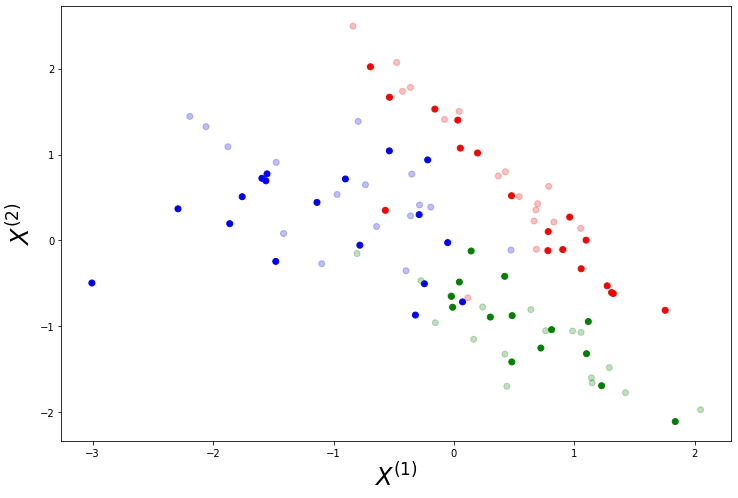

In [8]:
# define colormaps
cm = plt.cm.RdBu
cm_bright = ListedColormap(['blue', 'red', 'green'])

# visual exploration
plt.figure(figsize=(12,8))
plt.xlabel(r'$X^{(1)}$', size=24)
plt.ylabel(r'$X^{(2)}$', size=24)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.25)
plt.show()

We try to find the _k_ nearest neighbours in our train set for every test data point. The majority of labels of the _k_ closest train points determines the label of the test point. 

In [9]:
## EDIT THIS FUNCTION
def k_neighbours(X_train, X_test, k=5, return_distance=False):
  n_neighbours = k
  dist = []
  neigh_ind = []
  
  # compute distance from each point x_test in X_test to all points in X_train (hint: use python's list comprehension: [... for x_test in X_test])
  point_dist = [euclidian_distance(X_train, x_test) for x_test in X_test]

  # determine which k training points are closest to each test point
  for row in point_dist:
      enum_neigh = enumerate(row)
      sorted_neigh = sorted(enum_neigh, key=lambda x: x[1])[:k]

      ind_list = [tup[0] for tup in sorted_neigh]
      dist_list = [tup[1] for tup in sorted_neigh]

      dist.append(dist_list)
      neigh_ind.append(ind_list)
  
  # return distances together with indices of k nearest neighbouts
  if return_distance:
      return np.array(dist), np.array(neigh_ind)
  
  return np.array(neigh_ind)

Once we know which _k_ neighbours are closest to our test points, we can predict the labels of these test points.

We implement this in a "pythonic" way and call the previous function `k_neighbours` _within_ the next function `predict`.

Our `predict` function determines how any point $x_\text{test}$ in the test set is classified. Here, we only consider the case where each of the *k* neighbours contributes equally to the classification of $x_\text{test}$.

In [10]:
## EDIT THIS FUNCTION
def predict(X_train, y_train, X_test, k=5):
  # each of the k neighbours contributes equally to the classification of any data point in X_test  
  neighbours = k_neighbours(X_train, X_test, k=k)
  # count number of occurences of label with np.bincount and choose the label that has most with np.argmax (hint: use python's list comprehension: np.array([... for neighbour in neighbours]))
  y_pred = np.array([np.argmax(np.bincount(y_train[neighbour])) for neighbour in neighbours])

  return y_pred

To evaluate the algorithm in a more principled way, we need to implement a function that computes the mean accuracy by counting how many of the test points have been classified correctly and dividing this number by the total number of data points in our test set.

Again, we do this is in a pythonic way and call the previous `predict` function _within_ the next function `score`.

In [11]:
## EDIT THIS FUNCTION
def score(X_train, y_train, X_test, y_test, k=5):
  y_pred = predict(X_train, y_train, X_test, k=k)
  return np.mean(y_pred==y_test)

It is quite common to print both the train and test set accuracies.

In [12]:
k = 8
print('Train set mean accuracy:', score(X_train, y_train, X_train, y_train, k=k))
print('Test set mean accuracy:', score(X_train, y_train, X_test, y_test, k=k))

Train set mean accuracy: 0.84
Test set mean accuracy: 0.9


#### Questions
1. Does the solution above look reasonable?

The solutions given are very accurate, both averaging around 90%. Train set mean accuracy: 0.9142857142857143, Test set mean accuracy: 0.9. This is with $k=8$. Therefore are very reasonable results to achieve and with a k between 5 and 10 should produce optimal results.

2. Play around with different values for _k_. How does it influence the classification mean accuracy?

$k=5$: Train set mean accuracy: 0.8857142857142857, Test set mean accuracy: 0.9333333333333333. This is a strange result because the Train set has less accuracy than the Test set. However the Test set has a higher accuracy than the original $k=8$ test.

$k=10$: Train set mean accuracy: 0.9285714285714286, Test set mean accuracy: 0.8666666666666667. This result is also reasonable, however the Test set accuracy is lower than the others presented.

3. Compare the train and test set accuracy. Is there a difference? If so, what does the difference tell you?

As seen above the results are usually a different, but not by too much. The difference could give us an idea if the model is overfitted. This can be seen if the accuracy of the Train set is much higher than that of the Test set. This is due to the model just learning what the train data does, instead of finding the general classification, which is represented by our Test set. This is clear to see when $k=1$: Train set mean accuracy: 1.0, Test set mean accuracy: 0.8333333333333334. This shows that our model is perfect at classifying points that are already in the Train set, but for points not yet encountered only had 0.83 accuracy which is less than other models above.

4. Choose different ratios for the split between train and test set, and re-run the entire algorithm. What can you learn from different ratios?

I am going to try some different split ratios all with $k=8$ and see what results I get.

Split ratio 90:10, Train set mean accuracy: 0.9111111111111111, Test set mean accuracy: 0.9. This produces a very similar result to the 70:30.

Split ratio 50:50, Train set mean accuracy: 0.84, Test set mean accuracy: 0.82. This produced a lot worse results, showing that more training data was needed to find a suitable fit.

5. Considering an accuracy estimate on a test-split wich contains 30% of the dataset examples is 0.86, do we guarantee to obtain the same accuracy estimate when we apply our model on infinetely large unseen test examples, i.e. does the accuracy of your model on the test-split generalize well on unseen data? From this week's lecture notes, what would you suggest to improve our confidence in the accuracy estimate, so it is more closer estimate to the true accuracy when testing on unseen examples? 

No, this is only for 30 data points and therefore will still have a large variance of the true accuracy of the model. However to improve our confidence of the model, we can repeat the model on another randomly selected 30 data points and calculate the accuracy, and we can repeat this and take the mean of it for all the different models. and in such can show that it converges to the true accuracy of the model.

<a name="section-3"></a>

### 3 Hyperparameter Tuning for $k$ with _T-fold_ Cross [^](#outline)

Let's consider a systematic way to help select the best $k$ (i.e. the hyperparameter of $k$-NN). In previous cells, we splitted our data into 70%:30% for training:test examples. Now we need to choose the best $k$, but without looking at the accuracy on the test set (which should be used at the end to assess the predictive power of the model with the chosen $k$). To this end, we perform $T$-fold cross validation, where, **importantly**, we don't evaluate the accuracy of the model using the same examples on which we trained our model, rather on a held out validation set. We can achieve this by running $T$ experiments, and in each one we use disjoint partitions for the training and accuracy examples. By averaging the accuracy estimates over the $T$ experiments, we get a more precise and reliable accuracy estimate than before. If we consider $T=3$ folds, then we can run the three experiments and evaluate the average accuracy as in the figure below:

![cv](https://drive.google.com/uc?export=view&id=1aTZu9xNdgPb7_nBzs1cHrEpRjF31vK2M)


Finally, we need to isolate a separate set, before using cross-validation for hyperparameter tuning, to test our model after selecting the best performing $k$ for $k$-NN, so we further consider the following partitioning, which we will need to adhere with throughout the future notebooks and courseworks (i.e. in the problems when we need to use cross-validation for hyperparameter tuning then test on completely unseen data that are not involved in hyperparamter tuning):

![cv2](https://drive.google.com/uc?export=view&id=1d2fIBBhT0lzcUCYSfKcvCEaJT2df9-9K)



Let's consider a ratio 80:20 for training and test splits

In [53]:
# shuffling the rows in X and y
p = np.random.permutation(len(y))
X = X[p]
y = y[p]


# we split train to test as 80:20
split_rate = 0.8
X_train, X_test = np.split(X, [int(split_rate*(X.shape[0]))])
y_train, y_test = np.split(y, [int(split_rate*(y.shape[0]))])

Now let's partition our training split into 5-folds. We could store the corresponding indices only:

In [22]:
# Now we have a list of five index arrays, each correspond to one of the five folds.
folds_indexes = np.split(np.arange(len(y_train)), 5)
folds_indexes

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 array([16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
 array([32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]),
 array([48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]),
 array([64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79])]

In [24]:
# EDIT THIS FUNCTION
def cross_validation_score(X_train, y_train, folds, k):
  scores = []
  for i in range(len(folds)):
    val_indexes = folds[i]
    train_indexes = list(set(range(y_train.shape[0])) - set(val_indexes))
    
    X_train_i = X_train[train_indexes, :]
    y_train_i = y_train[train_indexes]


    X_val_i = X_train[val_indexes, :]
    y_val_i = y_train[val_indexes]

    score_i = score(X_train_i, y_train_i, X_val_i, y_val_i, k=k) # <- EDIT THIS LINE
    scores.append(score_i)

  # Return the average score
  return np.mean(scores)

Let's scan a range of $k$ in $[1, 30]$ and select the one with the best cross-validation accuracy.

In [25]:
def choose_best_k(X_train, y_train, folds, k_range):
  k_scores = np.zeros((len(k_range),))
  
  for i, k in enumerate(k_range):
    k_scores[i] = cross_validation_score(X_train, y_train, folds, k)
    print(f'CV_ACC@k={k}: {k_scores[i]:.3f}')

  best_k_index = np.argmax(k_scores)
  return k_range[best_k_index]


In [26]:
best_k = choose_best_k(X_train, y_train, folds_indexes, np.arange(1, 31))

print('best_k:', best_k)

CV_ACC@k=1: 0.787
CV_ACC@k=2: 0.825
CV_ACC@k=3: 0.800
CV_ACC@k=4: 0.825
CV_ACC@k=5: 0.812
CV_ACC@k=6: 0.838
CV_ACC@k=7: 0.825
CV_ACC@k=8: 0.812
CV_ACC@k=9: 0.825
CV_ACC@k=10: 0.812
CV_ACC@k=11: 0.800
CV_ACC@k=12: 0.762
CV_ACC@k=13: 0.775
CV_ACC@k=14: 0.775
CV_ACC@k=15: 0.762
CV_ACC@k=16: 0.775
CV_ACC@k=17: 0.775
CV_ACC@k=18: 0.775
CV_ACC@k=19: 0.775
CV_ACC@k=20: 0.787
CV_ACC@k=21: 0.800
CV_ACC@k=22: 0.775
CV_ACC@k=23: 0.775
CV_ACC@k=24: 0.775
CV_ACC@k=25: 0.762
CV_ACC@k=26: 0.738
CV_ACC@k=27: 0.738
CV_ACC@k=28: 0.738
CV_ACC@k=29: 0.762
CV_ACC@k=30: 0.738
best_k: 6



<a name="section-4"></a>

## Section 4:  Regression with kNN [^](#outline)

The kNN algorithm is mostly used for classification, but we can also utilise it for (non-linear) regression. Here, we calculate the label of every point in the test set as the mean of the _k_ nearest neighbours.

We start with defining a train set with sklearn's Californa housing data set. Note that this data set has normally 8 features, but we only extract the first feature, which corresponds to the median income in the district. The label is the median house value in the district.


In [27]:
data = fetch_california_housing(return_X_y=True)
X = data[0][:,0].reshape((-1, 1))
y = data[1]

X_std = standardise(X)

As before, we first divide the data into train and test set:

In [28]:
# shuffling the rows in X and y
p = np.random.permutation(len(y))
X = X_std[p]
y = y[p]

# we split train to test as 70:30
split_rate = 0.7
X_train, X_test = np.split(X, [int(split_rate*(X.shape[0]))])
y_train, y_test = np.split(y, [int(split_rate*(y.shape[0]))])

Let's plot it to get a sense how we can proceed. This time, we plot training examples in blue and test examples in red.

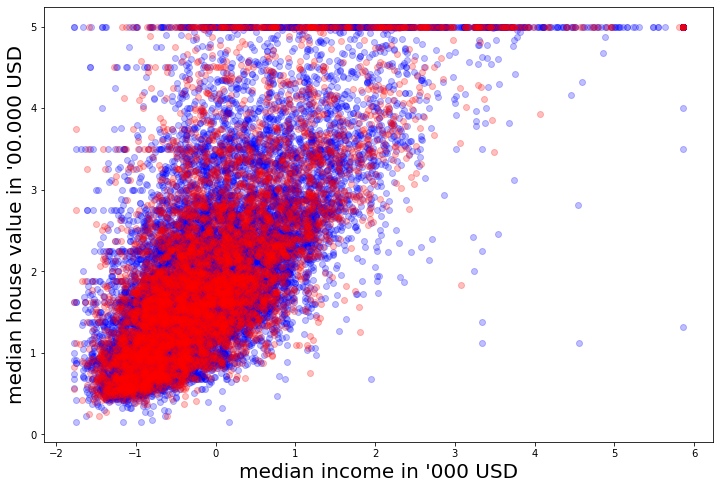

In [29]:
# visual exploration
plt.figure(figsize=(12,8))
plt.xlabel(r"median income in '000 USD", size=20)
plt.ylabel(r"median house value in '00.000 USD", size=20)
plt.scatter(X_train, y_train, c='blue', alpha=0.25)
plt.scatter(X_test, y_test, c='red', alpha=0.25)
plt.show()

As before, we need to define a predicting function which we call `reg_predict`.

In [35]:
## EDIT THIS FUNCTION
def reg_predict(X_train, y_train, X_test, k=20):
  # each of the k neighbours contributes equally to the classification of any data point in X_test  
  neighbours = k_neighbours(X_train, X_test, k=k)
  # compute mean over neighbours labels (hint: use python's list comprehension: np.array([... for neighbour in neighbours]))
  y_pred = np.array([np.mean(y_train[neighbour]) for neighbour in neighbours])

  return y_pred

In [41]:
# computing predictions... (takes a few minutes due to the high sample size)
k = 10
y_pred = reg_predict(X_train, y_train, X_test, k=k)

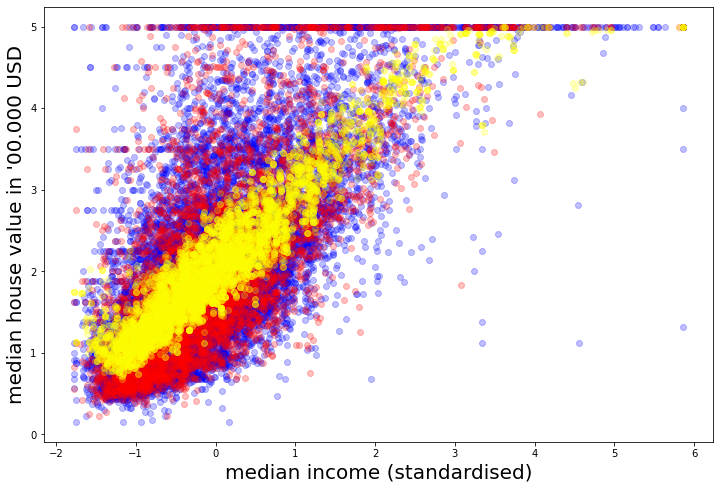

In [42]:
# ... and plotting them
plt.figure(figsize=(12,8))
plt.xlabel(r"median income (standardised)", size=20)
plt.ylabel(r"median house value in '00.000 USD", size=20)
plt.scatter(X_train, y_train, c='blue', alpha=0.25)
plt.scatter(X_test, y_test, c='red', alpha=0.25)
plt.scatter(X_test, y_pred, c='yellow', alpha=0.25)
plt.show()

To determine how well the prediction was, let us determine the $R^2$ score. The labels of the test set will be called $y$ and the predictions on the test data $\hat{y}$.
$$
R^2(y, \hat{y}) = 1 - \frac{\sum_{i=1}^n (y_i - \hat{y}_i)^2}{\sum_{i=1}^n (y_i - \bar{y})^2} \, ,
$$
where $\bar{y} = \frac{1}{n} \sum_{i=1}^n y_i$.

In [43]:
## EDIT THIS FUNCTION
def r2_score(y_test, y_pred):
  numerator = np.sum((y_test-y_pred)**2)
  y_avg = np.mean(y_test)
  denominator = np.sum((y_test-y_avg)**2)
  return 1 - numerator/denominator

In [44]:
print(r'R2 score:', r2_score(y_test, y_pred))

R2 score: 0.42785807155495725


#### Questions
1. Does the solution above look reasonable? What does your $R^2$ value tell you?
When looking at the graph it looks reasonable because there is a lot of variance in the red compared to the yellow, which means that our model doesn't predict the red perfectly, but it does create the general pattern of the data. The $R^2$ value tells me that on average 45% of the data will be correct using this model.

2. Play around with different values for _k_. How does it influence the regression?

$k=10$, $R^2=42$%. This regression was much more impacted by outliers and therefore overfitting the training data.

$ $

3. Like we did in classification, excercise with implementing cross-validation to find the best performing k on the regression task.

I have implemented this below

4. Compare the train and test set accuracy. Is there a difference? If so, what does the difference tell you?



5. Choose different ratios for the split between train and test set, and re-run the entire algorithm. What can you learn from different ratios?



6. Can you replicate your results using [sklearn](https://scikit-learn.org/stable/modules/neighbors.html)?

I have implemented an sklearn version using the neighbors KneighborsRehression class.

7. Based on sklearn's documentation, can you see any differences in the algorithms that are implemented in sklearn?


In [57]:
def choose_best_k_reg(X_train, y_train, folds, k_range):
  k_scores = np.zeros((len(k_range),))
  
  for i, k in enumerate(k_range):
    k_scores[i] = cross_validation_score_reg(X_train, y_train, folds, k)
    print(f'CV_ACC@k={k}: {k_scores[i]:.3f}')

  best_k_index = np.argmax(k_scores)
  return k_range[best_k_index]

In [47]:
def cross_validation_score_reg(X_train, y_train, folds, k):
  scores = []
  for i in range(len(folds)):
    val_indexes = folds[i]
    train_indexes = list(set(range(y_train.shape[0])) - set(val_indexes))
    
    X_train_i = X_train[train_indexes, :]
    y_train_i = y_train[train_indexes]


    X_val_i = X_train[val_indexes, :]
    y_val_i = y_train[val_indexes]
    
    y_pred_i = reg_predict(X_train_i, y_train_i, X_val_i, k=k)
    
    score_i = r2_score(y_val_i, y_pred_i)
    scores.append(score_i)

  # Return the average score
  return np.mean(scores)

In [48]:
def reg_predict_best_k(X_train, y_train, X_test, folds, k_range):
  # choose best k
  best_k = choose_best_k_reg(X_train, y_train, folds, k_range)
  # each of the k neighbours contributes equally to the classification of any data point in X_test  
  neighbours = k_neighbours(X_train, X_test, k=best_k)
  # compute mean over neighbours labels (hint: use python's list comprehension: np.array([... for neighbour in neighbours]))
  y_pred = np.array([np.mean(y_train[neighbour]) for neighbour in neighbours])

  return y_pred


In [59]:
k_range = np.arange(1, 31)
folds = 5
folds_indexes = np.split(np.arange(len(y_train)), [int(x*len(y_train)/folds) for x in range(1, folds)])
y_pred = reg_predict_best_k(X_train, y_train, X_test, folds_indexes, k_range)

CV_ACC@k=1: -0.018
CV_ACC@k=2: 0.234
CV_ACC@k=3: 0.313
CV_ACC@k=4: 0.356
CV_ACC@k=5: 0.384
CV_ACC@k=6: 0.401
CV_ACC@k=7: 0.415
CV_ACC@k=8: 0.423
CV_ACC@k=9: 0.430
CV_ACC@k=10: 0.435
CV_ACC@k=11: 0.440
CV_ACC@k=12: 0.444
CV_ACC@k=13: 0.447
CV_ACC@k=14: 0.450
CV_ACC@k=15: 0.452
CV_ACC@k=16: 0.454
CV_ACC@k=17: 0.456
CV_ACC@k=18: 0.459
CV_ACC@k=19: 0.460
CV_ACC@k=20: 0.461
CV_ACC@k=21: 0.462
CV_ACC@k=22: 0.463
CV_ACC@k=23: 0.464
CV_ACC@k=24: 0.464
CV_ACC@k=25: 0.465
CV_ACC@k=26: 0.466
CV_ACC@k=27: 0.467
CV_ACC@k=28: 0.467
CV_ACC@k=29: 0.468
CV_ACC@k=30: 0.468


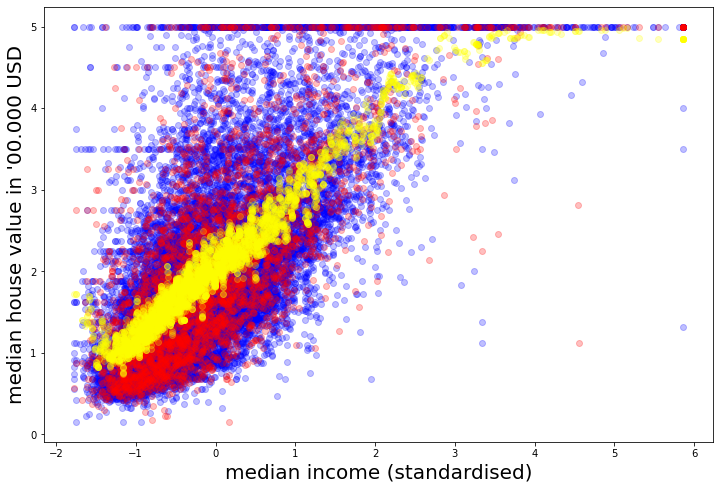

In [60]:
# ... and plotting them
plt.figure(figsize=(12,8))
plt.xlabel(r"median income (standardised)", size=20)
plt.ylabel(r"median house value in '00.000 USD", size=20)
plt.scatter(X_train, y_train, c='blue', alpha=0.25)
plt.scatter(X_test, y_test, c='red', alpha=0.25)
plt.scatter(X_test, y_pred, c='yellow', alpha=0.25)
plt.show()

In [61]:
print(r'R2 score:', r2_score(y_test, y_pred))

R2 score: 0.49198303149471667


In [70]:
k = 30
neigh = skneigh.KNeighborsRegressor(n_neighbors=k)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)

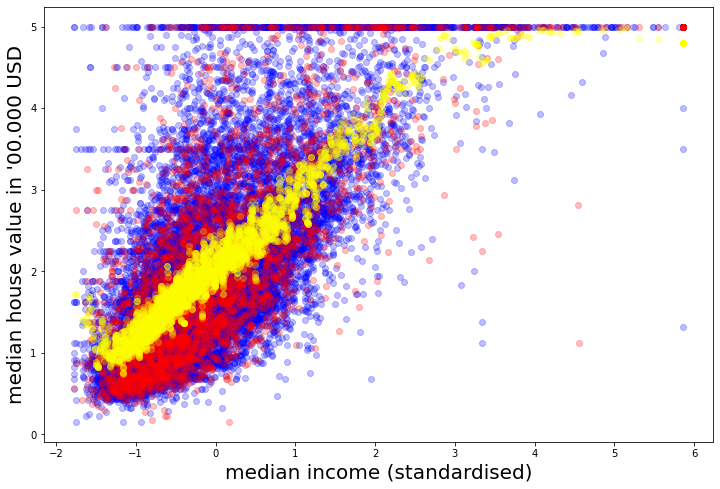

In [71]:
# ... and plotting them
plt.figure(figsize=(12,8))
plt.xlabel(r"median income (standardised)", size=20)
plt.ylabel(r"median house value in '00.000 USD", size=20)
plt.scatter(X_train, y_train, c='blue', alpha=0.25)
plt.scatter(X_test, y_test, c='red', alpha=0.25)
plt.scatter(X_test, y_pred, c='yellow', alpha=0.25)
plt.show()

In [72]:
print(r'R2 score:', neigh.score(X_test, y_test))

R2 score: 0.49115904027241153
